<a href="https://colab.research.google.com/github/mukesh-kumar-singh/RatesPopMiniSchool2021/blob/master/GW_population_inference.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Population Inference on GWTC-1

`GWPopulation` builds upon [bilby](git.ligo.org/lscsoft/bilby) ([arXiv:1811.02042](https://arxiv.org/abs/1811.02042)) to provide simple, modular, user-friendly, population inference.

Currently implemented models include:

- One and two component mass distributions in primary mass and mass ratio, e.g., Talbot & Thrane (2018) ([arXiv:1801:02699](https://arxiv.org/abs/1801.02699)), Fishbach & Holz (2018) ([arXiv:1709.08584](https://arxiv.org/abs/1709.08584)).
- The same mass distributions but independent but identically distributed primary and secondary.
- Half-Gaussian + isotropic spin tilt distribution from Talbot & Thrane (2017) ([arXiv:1704.08370](https://arxiv.org/abs/1704.08370)).
- Beta spin magnitude distribution from Wysocki+ (2018) ([arXiv:1805:06442](https://arxiv.org/abs/1805.06442)).
- Each of these are also available with independent but identically distributed spins.
- Redshift evolution model as in Fishbach+ (2018) ([arXiv:1805.10270](https://arxiv.org/abs/1805.10270)).
- More to come and any contributions welcome...

For more information see the [git repository](https://github.com/ColmTalbot/gwpopulation), [documentation](https://colmtalbot.github.io/gwpopulation/).


## Install some packages

- `gwpopulation` has the population model code.
- `cupy` allows use to leverage the GPU.

If you're using colab.research.google.com you will want to choose a GPU-accelerated runtime.

"runtime"->"change runtime type"->"Hardware accelerator = GPU"

In [ ]:
#! pip install gwpopulation bilby numpy scipy==1.7.1
#! pip install deepdish

In [ ]:
#!curl https://colab.chainer.org/install | sh -

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  1580  100  1580    0     0   8102      0 --:--:-- --:--:-- --:--:--  8102
+ apt -y -q install cuda-libraries-dev-10-0
Reading package lists...
Building dependency tree...
Reading state information...
cuda-libraries-dev-10-0 is already the newest version (10.0.130-1).
0 upgraded, 0 newly installed, 0 to remove and 40 not upgraded.
+ pip install -q cupy-cuda100  chainer 
+ set +ex
Installation succeeded!


# Loading PE data for O1 + O2

In [ ]:
#!wget https://dcc.ligo.org/public/0157/P1800370/002/GWTC-1_sample_release.tar.gz
#!tar -xvzf GWTC-1_sample_release.tar.gz

--2021-08-13 06:54:01--  https://dcc.ligo.org/public/0157/P1800370/002/GWTC-1_sample_release.tar.gz
Resolving dcc.ligo.org (dcc.ligo.org)... 131.215.125.144
Connecting to dcc.ligo.org (dcc.ligo.org)|131.215.125.144|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 89895447 (86M) [application/x-gzip]
Saving to: ‘GWTC-1_sample_release.tar.gz.1’

GWTC-1_sample_relea 100%[===================>]  85.73M  69.0MB/s    in 1.2s    

2021-08-13 06:54:02 (69.0 MB/s) - ‘GWTC-1_sample_release.tar.gz.1’ saved [89895447/89895447]

./GWTC-1_sample_release/
./GWTC-1_sample_release/GW170729_GWTC-1.hdf5
./GWTC-1_sample_release/GW151226_GWTC-1.hdf5
./GWTC-1_sample_release/GW170809_GWTC-1.hdf5
./GWTC-1_sample_release/GW170104_GWTC-1.hdf5
./GWTC-1_sample_release/GW170817_GWTC-1.hdf5
./GWTC-1_sample_release/GW170608_GWTC-1.hdf5
./GWTC-1_sample_release/GW170814_GWTC-1.hdf5
./GWTC-1_sample_release/GW151012_GWTC-1.hdf5
./GWTC-1_sample_release/GW170809_priorChoices_GWTC-1.hdf5
./GWTC-1_sam

# Mounting the google drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Imports

Import the packages required for the script

In [ ]:
%matplotlib inline

import h5py
import deepdish as dd

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d
from astropy import cosmology, units

import bilby as bb
from bilby.core.prior import LogUniform, PriorDict, Uniform
from bilby.hyper.model import Model
import gwpopulation as gwpop
xp = gwpop.cupy_utils.xp

## Load posteriors

We're using the posteriors from the GWTC-1 data release.

We need to change the names of the parameters to make them work with the code.

In [ ]:
parameter_translator = dict(
    mass_1_det='m1_detector_frame_Msun',
    mass_2_det='m2_detector_frame_Msun',
    luminosity_distance='luminosity_distance_Mpc',
    a_1='spin1',
    a_2='spin2',
    cos_tilt_1='costilt1',
    cos_tilt_2='costilt2')

posteriors = list()
priors = list()

file_str = './GWTC-1_sample_release/GW{}_GWTC-1.hdf5'

events = ['150914', '151012', '151226', '170104', '170608',
          '170729', '170809', '170814', '170818', '170823']
for event in events:
    _posterior = pd.DataFrame()
    _prior = pd.DataFrame()
    with h5py.File(file_str.format(event)) as ff:
        for my_key, gwtc_key in parameter_translator.items():
            _posterior[my_key] = ff['IMRPhenomPv2_posterior'][gwtc_key]
            _prior[my_key] = ff['prior'][gwtc_key]
    posteriors.append(_posterior)
    priors.append(_prior)

In [ ]:
luminosity_distances = np.linspace(1, 10000, 1000)
redshifts = np.array([
    cosmology.z_at_value(
        cosmology.Planck15.luminosity_distance, dl * units.Mpc)
    for dl in luminosity_distances])
dl_to_z = interp1d(luminosity_distances, redshifts)

luminosity_prior = luminosity_distances ** 2

dz_ddl = np.gradient(redshifts, luminosity_distances)

redshift_prior = interp1d(
    redshifts, luminosity_prior / dz_ddl / (1 + redshifts))

## Add some weights to posterior

Make sure the posterior `DataFrames` contain the appropriate quantities.

We could include a `prior` column, this is the prior used in the initial sampling stage.
This is used to weight the samples in the likelihood.

In [ ]:
for posterior in posteriors:
    posterior['redshift'] = dl_to_z(posterior['luminosity_distance'])
    posterior['mass_1'] = posterior['mass_1_det'] / (1 + posterior['redshift'])
    posterior['mass_2'] = posterior['mass_2_det'] / (1 + posterior['redshift'])
    posterior['mass_ratio'] = posterior['mass_2'] / posterior['mass_1']

## Specify the model

Choose which population models we want to use. 

For the mass distribution we use 

`gwpopulation.models.mass.two_component_primary_mass_ratio`.

This is a powerlaw mass distribution with powerlaw mass ratio distribution.

In [ ]:
model = Model([gwpop.models.mass.power_law_primary_mass_ratio])

## Selection effects

Gravitational-wave surveys suffer from Malmquist bias.

In order to measure the true, astrophysical, distribution we must include a term to account for this in our population analyses.

The way the likelihood is structured, this can be any object that evaluates to give the observed spactime volume as a function of the population parameters.

We define classes so that various bits of metadata can be stored.

The data for calculating this is not easily available.
We use a very rough toy model to get the general scaling for the primary mass, $VT(m) \sim m^{1.6}$.
This value was chosen to get a decent agreement with the more complex model.

**I do not recommend using this toy function for science.**

In [ ]:
_vt_data = dd.io.load('/content/drive/My Drive/RatesPopMiniSchool2021/vt.h5')
vt_data = dict()
vt_data['mass_1'] = xp.array(_vt_data['m1'])
vt_data['mass_ratio'] = xp.array(_vt_data['q'])
vt_data['vt'] = xp.array(_vt_data['vt_early_high']*_vt_data['quadratic_calibration'])
vt = vt_data['vt']
vt_evaluator = gwpop.vt.GridVT(
    model=gwpop.models.mass.power_law_primary_mass_ratio, data=vt_data)

Text(0, 0.5, '$q$')

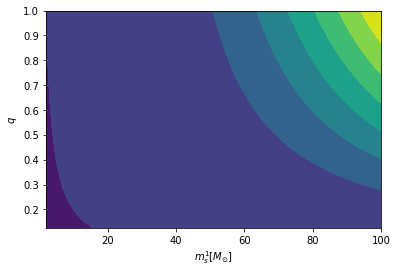

In [ ]:
plt.contourf(_vt_data["m1"], _vt_data["q"], _vt_data['vt_early_high']*_vt_data['quadratic_calibration'])
plt.xlabel('$m^1_s$[$M_{\odot}$]')
plt.ylabel('$q$')
plt.colorbar('VT')

## Define the likelihood

The `HyperparameterLikelihood` marginalises over the local merger rate, with a uniform-in-log prior.

To also estimate the rate use the `RateLikelilhood` (see further on in the notebook).

We provide:
- `posteriors`: a list of `pandas` DataFrames
- `hyper_prior`: our population model, as defined above
- `selection_function`: anything which evaluates the selection function

We can also provide:
- `conversion_function`: this converts between the parameters we sample in and those needed by the model, e.g., for sampling in the mean and variance of the beta distribution
- `max_samples`: the maximum number of samples to use from each posterior, this defaults to the length of the shortest posterior

We may get a warning telling us `cupy` is not available and so `numpy` is for the likelihood evaluation.
This will go away if you have a GPU and `cupy` installed.

In [ ]:
fast_likelihood = gwpop.hyperpe.HyperparameterLikelihood(
    posteriors=posteriors, hyper_prior=model,
    selection_function=vt_evaluator)

07:02 bilby INFO    : No prior values provided, defaulting to 1.


## Define the prior

This is the standard method to define the prior distribution within `bilby`.

The labels are used in plotting.

Numbers are converted to delta function priors and are not sampled.

There are many other distributions available, see the code/documentation for a full list.

In [ ]:
fast_priors = PriorDict()

# mass
fast_priors['alpha'] = Uniform(minimum=-2, maximum=4, latex_label='$\\alpha$')
fast_priors['beta'] = Uniform(minimum=-4, maximum=12, latex_label='$\\beta$')
fast_priors['mmin'] = Uniform(minimum=5, maximum=10, latex_label='$m_{\\min}$')
fast_priors['mmax'] = Uniform(minimum=20, maximum=60, latex_label='$m_{\\max}$')

## Run the sampler

We'll use the sampler `dynesty` and use a small number of live points to reduce the runtime.

This is painfully slow without using the GPU version.
If you have a GPU it will just work.

Other samplers are available, `cpnest` gave the best results for the O1+O2 data, however it isn't currently compatible with the GPU likelihood.

`bilby` times a single likelihood evaluation before beginning the run

We do a call before running to sampler as `cupy` compiles kernels the first time they are evaluated and so the estimate of the evaluation time would be off.

In [ ]:
fast_likelihood.parameters.update(fast_priors.sample())
fast_likelihood.log_likelihood_ratio()

fast_result = bb.run_sampler(
    likelihood=fast_likelihood, priors=fast_priors, sampler='dynesty',
    nlive=100, label='fast')

20:00 bilby INFO    : Running for label 'fast', output will be saved to 'outdir'
20:00 bilby INFO    : Search parameters:
20:00 bilby INFO    :   alpha = Uniform(minimum=-2, maximum=4, name=None, latex_label='$\\alpha$', unit=None, boundary=None)
20:00 bilby INFO    :   beta = Uniform(minimum=-4, maximum=12, name=None, latex_label='$\\beta$', unit=None, boundary=None)
20:00 bilby INFO    :   mmin = Uniform(minimum=5, maximum=10, name=None, latex_label='$m_{\\min}$', unit=None, boundary=None)
20:00 bilby INFO    :   mmax = Uniform(minimum=20, maximum=60, name=None, latex_label='$m_{\\max}$', unit=None, boundary=None)
20:00 bilby INFO    : Single likelihood evaluation took 5.906e-03 s


20:00 bilby INFO    : Using sampler Dynesty with kwargs {'bound': 'multi', 'sample': 'rwalk', 'verbose': True, 'periodic': None, 'reflective': None, 'check_point_delta_t': 1800, 'nlive': 100, 'first_update': None, 'walks': 100, 'npdim': None, 'rstate': None, 'queue_size': 1, 'pool': None, 'use_pool': None, 'live_points': None, 'logl_args': None, 'logl_kwargs': None, 'ptform_args': None, 'ptform_kwargs': None, 'enlarge': 1.5, 'bootstrap': None, 'vol_dec': 0.5, 'vol_check': 8.0, 'facc': 0.2, 'slices': 5, 'update_interval': 60, 'print_func': <bound method Dynesty._print_func of <bilby.core.sampler.dynesty.Dynesty object at 0x7f1bc3365350>>, 'dlogz': 0.1, 'maxiter': None, 'maxcall': None, 'logl_max': inf, 'add_live': True, 'print_progress': True, 'save_bounds': False, 'n_effective': None, 'maxmcmc': 5000, 'nact': 5}
20:00 bilby INFO    : Checkpoint every check_point_delta_t = 600s
20:00 bilby INFO    : Using dynesty version 1.1
20:00 bilby INFO    : Using the bilby-implemented rwalk sample

Plotting posteriors for hyper parameters

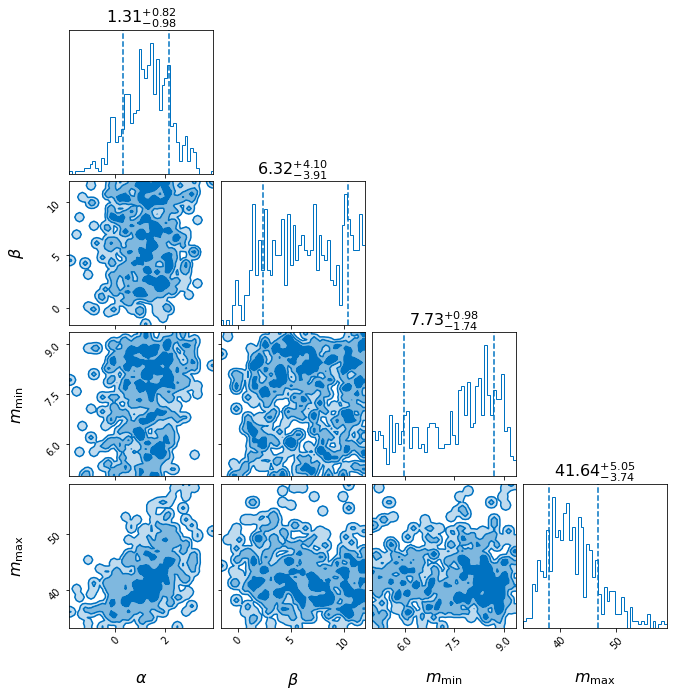

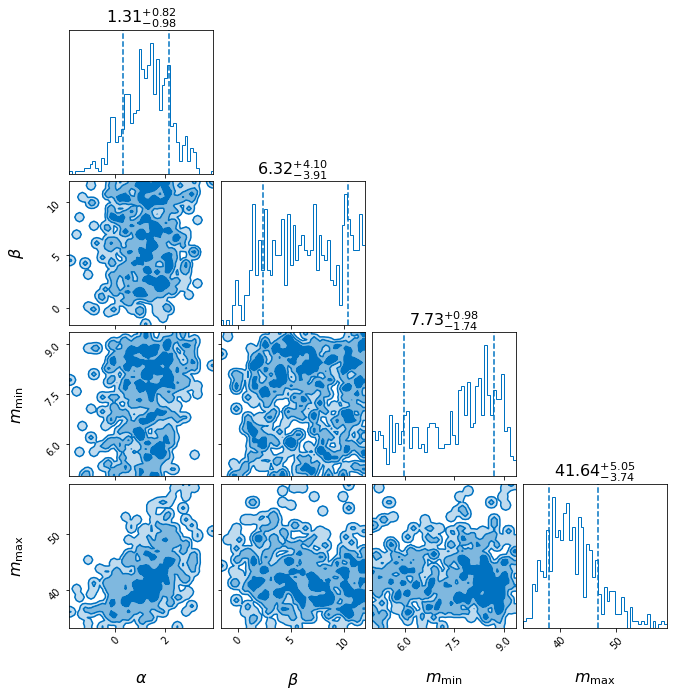

In [ ]:
fast_result.plot_corner(save=False)

# Exercise:

1. In the above case, we have accounted for selection effects in mass models. Repeat the above steps without passing the `vt_evaluator` and see how strongly it affects your inference of hyper-parameters on mass-models.

2. You may also choose a different mass model (a little more complicated one) e.g. `gwpop.models.mass.two_component_primary_mass_ratio` and repeat the analysis. In this case, you can use the approximate selection effects as a function (code given below) in `gwpop.hyperpe.HyperparameterLikelihood`. It might take some time, you are encourgaed to do this in your own time.

In [ ]:
masses = xp.linspace(3, 100, 1000)
vts = masses**1.6

def toy_vt_calculator(kwargs):
    params = {key: kwargs[key] for key in 
              ['alpha', 'mmin', 'mmax', 'lam', 'mpp', 'sigpp']}
    p_m = gwpop.models.mass.two_component_single(
        masses, **params)
    return gwpop.cupy_utils.trapz(p_m * vts, masses)

# Add spin model also

For spins we use

`gwpopulation.models.spin.iid_spin`

Where the spins of the two black holes are independently and identically distirbuted with a beta distribution for the magnitude and an isotropic + half-Gaussian for the cosine tilts.

In [ ]:
model = Model([gwpop.models.mass.two_component_primary_mass_ratio, gwpop.models.spin.iid_spin])

In [ ]:
fast_2models_likelihood = gwpop.hyperpe.HyperparameterLikelihood(
    posteriors=posteriors, hyper_prior=model)

In [ ]:
fast_2models_priors = PriorDict()

# mass
fast_2models_priors['alpha'] = Uniform(minimum=-2, maximum=4, latex_label='$\\alpha$')
fast_2models_priors['beta'] = Uniform(minimum=-4, maximum=12, latex_label='$\\beta$')
fast_2models_priors['mmin'] = Uniform(minimum=5, maximum=10, latex_label='$m_{\\min}$')
fast_2models_priors['mmax'] = Uniform(minimum=20, maximum=60, latex_label='$m_{\\max}$')
fast_2models_priors['lam'] = Uniform(minimum=0, maximum=1, latex_label='$\\lambda_{m}$')
fast_2models_priors['mpp'] = Uniform(minimum=10, maximum=50, latex_label='$\\mu_{m}$')
fast_2models_priors['sigpp'] = Uniform(minimum=0, maximum=10, latex_label='$\\sigma_{m}$')
# spin
fast_2models_priors['amax'] = 1
fast_2models_priors['alpha_chi'] = Uniform(minimum=-4, maximum=12, latex_label='$\\alpha_{\\chi}$')
fast_2models_priors['beta_chi'] = Uniform(minimum=-4, maximum=12, latex_label='$\\beta_{\\chi}$')

In [ ]:
fast_2models_likelihood.parameters.update(fast_2models_priors.sample())
fast_2models_likelihood.log_likelihood_ratio()

fast_result = bb.run_sampler(
    likelihood=fast_2models_likelihood, priors=fast_2models_priors, sampler='dynesty',
    nlive=100, label='fast_2models')

07:10 bilby INFO    : Running for label 'fast', output will be saved to 'outdir'
07:10 bilby INFO    : Search parameters:
07:10 bilby INFO    :   alpha = Uniform(minimum=-2, maximum=4, name=None, latex_label='$\\alpha$', unit=None, boundary=None)
07:10 bilby INFO    :   beta = Uniform(minimum=-4, maximum=12, name=None, latex_label='$\\beta$', unit=None, boundary=None)
07:10 bilby INFO    :   mmin = Uniform(minimum=5, maximum=10, name=None, latex_label='$m_{\\min}$', unit=None, boundary=None)
07:10 bilby INFO    :   mmax = Uniform(minimum=20, maximum=60, name=None, latex_label='$m_{\\max}$', unit=None, boundary=None)
07:10 bilby INFO    :   lam = Uniform(minimum=0, maximum=1, name=None, latex_label='$\\lambda_{m}$', unit=None, boundary=None)
07:10 bilby INFO    :   mpp = Uniform(minimum=10, maximum=50, name=None, latex_label='$\\mu_{m}$', unit=None, boundary=None)
07:10 bilby INFO    :   sigpp = Uniform(minimum=0, maximum=10, name=None, latex_label='$\\sigma_{m}$', unit=None, boundary=N

07:10 bilby INFO    : Using sampler Dynesty with kwargs {'bound': 'multi', 'sample': 'rwalk', 'verbose': True, 'periodic': None, 'reflective': None, 'check_point_delta_t': 1800, 'nlive': 100, 'first_update': None, 'walks': 100, 'npdim': None, 'rstate': None, 'queue_size': 1, 'pool': None, 'use_pool': None, 'live_points': None, 'logl_args': None, 'logl_kwargs': None, 'ptform_args': None, 'ptform_kwargs': None, 'enlarge': 1.5, 'bootstrap': None, 'vol_dec': 0.5, 'vol_check': 8.0, 'facc': 0.2, 'slices': 5, 'update_interval': 60, 'print_func': <bound method Dynesty._print_func of <bilby.core.sampler.dynesty.Dynesty object at 0x7f03d2304590>>, 'dlogz': 0.1, 'maxiter': None, 'maxcall': None, 'logl_max': inf, 'add_live': True, 'print_progress': True, 'save_bounds': False, 'n_effective': None, 'maxmcmc': 5000, 'nact': 5}
07:10 bilby INFO    : Checkpoint every check_point_delta_t = 600s
07:10 bilby INFO    : Using dynesty version 1.1
07:10 bilby INFO    : Using the bilby-implemented rwalk sample

In [ ]:
fast_result.plot_corner(save=False)

## Define a new model

### Let's define a new population model for BNS. 

Just as an example we'll use a Gaussian distribution bounded between $[1 M_{\odot}, 2 M_{\odot}]$.

$$p(m_1, m_2) = N \exp \left(- \frac{\left((m_1 - \mu)^2 + (m_2 - \mu)^2\right)}{2 \sigma^2}\right) \quad : \quad 1 \leq m_2 \leq m_1 \leq 2$$

We see that this function takes three arguments:
- `dataset`: this is common to all of the population models in `gwpopulation`, it is a dictionary containing the data to be evaluated, here it is assumed to contain entries for `mass_1` and `mass_2`, the _source-frame_ masses.
- `mu_bns`: the peak of the bns mass distribution.
- `sigma_bns`: the width of the bns mass distribution.

In [ ]:
def truncated_gaussian_primary_secondary_identical(dataset, mu_bns, sigma_bns):
    prob = gwpop.utils.truncnorm(
        dataset['mass_1'], mu=mu_bns, sigma=sigma_bns, low=1, high=2)
    prob *= gwpop.utils.truncnorm(
        dataset['mass_2'], mu=mu_bns, sigma=sigma_bns, low=1, high=2)
    prob *= (dataset['mass_1'] >= dataset['mass_2'])
    prob *= 2
    return prob

## Load GW170817 posterior

This is just the same as above.

In [ ]:
posterior = pd.DataFrame()
prior = pd.DataFrame()
with h5py.File('./GWTC-1_sample_release/GW170817_GWTC-1.hdf5') as ff:
    for my_key, gwtc_key in parameter_translator.items():
        try:
            posterior[my_key] = ff['IMRPhenomPv2NRT_lowSpin_posterior'][gwtc_key]
            prior[my_key] = ff['IMRPhenomPv2NRT_lowSpin_prior'][gwtc_key]
        except ValueError:
            pass
        
posterior['redshift'] = dl_to_z(posterior['luminosity_distance'])
posterior['mass_1'] = posterior['mass_1_det'] / (1 + posterior['redshift'])
posterior['mass_2'] = posterior['mass_2_det'] / (1 + posterior['redshift'])

## Define the new likelihood

We use the same likelihood as before.

_Note_:
- This time we cast our posterior to a list while creating the likelihood.
- We pass the function rather than a `Model` object as before, `bilby` will turn this into a `Model` for internal use.
- We've removed the selection and conversion functions as they aren't needed here (yes, a selection function is techinically needed).

In [ ]:
bns_likelihood = gwpop.hyperpe.HyperparameterLikelihood(
    posteriors=[posterior],
    hyper_prior=truncated_gaussian_primary_secondary_identical)

20:23 bilby INFO    : No prior values provided, defaulting to 1.


## Define the new prior

Just as before.

In [ ]:
bns_priors = PriorDict()
bns_priors['mu_bns'] = Uniform(minimum=1, maximum=2, latex_label='$\\mu_{bns}$')
bns_priors['sigma_bns'] = LogUniform(minimum=1e-2, maximum=1, latex_label='$\\sigma_{bns}$')

In [ ]:
bns_likelihood.parameters.update(bns_priors.sample())
bns_likelihood.log_likelihood_ratio()

bns_result = bb.run_sampler(
    likelihood=bns_likelihood, priors=bns_priors, sampler='dynesty',
    nlive=1000)

20:24 bilby INFO    : Running for label 'label', output will be saved to 'outdir'
20:24 bilby INFO    : Search parameters:
20:24 bilby INFO    :   mu_bns = Uniform(minimum=1, maximum=2, name=None, latex_label='$\\mu_{bns}$', unit=None, boundary=None)
20:24 bilby INFO    :   sigma_bns = LogUniform(minimum=0.01, maximum=1, name=None, latex_label='$\\sigma_{bns}$', unit=None, boundary=None)
20:24 bilby INFO    : Single likelihood evaluation took 1.254e-03 s


20:24 bilby INFO    : Using sampler Dynesty with kwargs {'bound': 'multi', 'sample': 'rwalk', 'verbose': True, 'periodic': None, 'reflective': None, 'check_point_delta_t': 1800, 'nlive': 1000, 'first_update': None, 'walks': 100, 'npdim': None, 'rstate': None, 'queue_size': 1, 'pool': None, 'use_pool': None, 'live_points': None, 'logl_args': None, 'logl_kwargs': None, 'ptform_args': None, 'ptform_kwargs': None, 'enlarge': 1.5, 'bootstrap': None, 'vol_dec': 0.5, 'vol_check': 8.0, 'facc': 0.2, 'slices': 5, 'update_interval': 600, 'print_func': <bound method Dynesty._print_func of <bilby.core.sampler.dynesty.Dynesty object at 0x7f1ba9987810>>, 'dlogz': 0.1, 'maxiter': None, 'maxcall': None, 'logl_max': inf, 'add_live': True, 'print_progress': True, 'save_bounds': False, 'n_effective': None, 'maxmcmc': 5000, 'nact': 5}
20:24 bilby INFO    : Checkpoint every check_point_delta_t = 600s
20:24 bilby INFO    : Using dynesty version 1.1
20:24 bilby INFO    : Using the bilby-implemented rwalk samp

20:32 bilby INFO    : Sampling time: 0:07:49.300680
20:32 bilby INFO    : Summary of results:
nsamples: 7346
ln_noise_evidence:    nan
ln_evidence:    nan +/-  0.066
ln_bayes_factor:  0.957 +/-  0.066



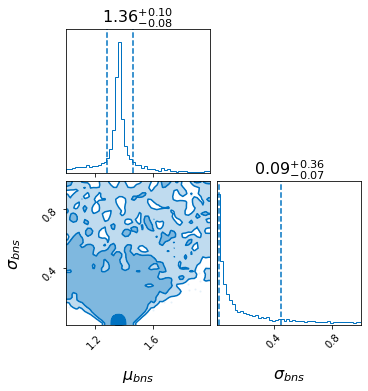

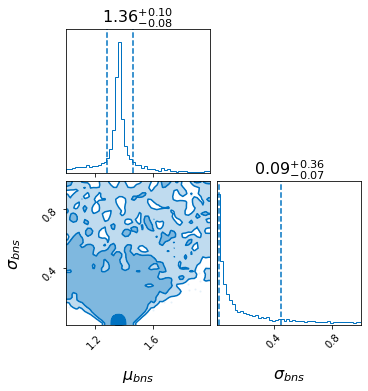

In [ ]:
bns_result.plot_corner(save=False)

## Do it all

Let's put together a run with models for the mass, spin and redshift distributions.

**This will not give sensible answers because VT is not estimated.**

The data for VT estimation isn't available in this notebook.

Note that the redshift model is a class and so is called slightly differently.
This is to enable caching of expensive data internally.
To call this `bilby>=0.4.2` is required.

In [ ]:
full_model = Model([
    gwpop.models.mass.two_component_primary_mass_ratio,
    gwpop.models.spin.iid_spin_magnitude_beta,
    gwpop.models.spin.independent_spin_orientation_gaussian_isotropic,
    gwpop.models.redshift.PowerLawRedshift()])

## Update sampling prior

We need to update the sampling prior to account for the new redshift evolution model.

Fortunately, we defined an interpolant for this earlier.

In [ ]:
for posterior in posteriors:
    posterior['prior'] = redshift_prior(posterior['redshift'])

## Likelihood

We use a different likelihood class `RateLikelihood`, this will simultaneously estimate the local merger rate as well as the population distribution.

This is created just as before.

In [ ]:
full_likelihood = gwpop.hyperpe.RateLikelihood(
    posteriors=posteriors, hyper_prior=full_model)

## Prior

This is just a longer version of the previous.

In [ ]:
full_priors = PriorDict()

# rate
fast_priors['rate'] = LogUniform(minimum=1e-20, maximum=1e20, latex_label='$R$')
# mass
full_priors['alpha'] = Uniform(minimum=-4, maximum=12, latex_label='$\\alpha$')
full_priors['beta'] = Uniform(minimum=-4, maximum=12, latex_label='$\\beta$')
full_priors['mmin'] = Uniform(minimum=5, maximum=10, latex_label='$m_{\\min}$')
full_priors['mmax'] = Uniform(minimum=20, maximum=60, latex_label='$m_{\\max}$')
full_priors['lam'] = Uniform(minimum=0, maximum=1, latex_label='$\\lambda_{m}$')
full_priors['mpp'] = Uniform(minimum=20, maximum=50, latex_label='$\\mu_{m}$')
full_priors['sigpp'] = Uniform(minimum=0, maximum=10, latex_label='$\\sigma_{m}$')
# spin magnitude
full_priors['amax'] = 1
full_priors['alpha_chi'] = Uniform(minimum=-4, maximum=12, latex_label='$\\alpha_{\\chi}$')
full_priors['beta_chi'] = Uniform(minimum=-4, maximum=12, latex_label='$\\beta_{\\chi}$')
# spin orientation
full_priors['xi_spin'] = Uniform(minimum=0, maximum=1, latex_label='$\\xi$')
full_priors['sigma_1'] = Uniform(minimum=0, maximum=4, latex_label='$\\sigma{1}$')
full_priors['sigma_2'] = Uniform(minimum=0, maximum=4, latex_label='$\\sigma{2}$')
# redshift evolution
full_priors['lamb'] = Uniform(minimum=-25, maximum=25, latex_label='$\\lambda_{z}$')

# Run the sampler

In [ ]:
full_likelihood.parameters.update(full_priors.sample())
full_likelihood.log_likelihood_ratio()

full_result = run_sampler(
    likelihood=full_likelihood, priors=full_priors, sampler='dynesty',
    nlive=100)